# Implementacion del codigo del paper: Less Is More: Linear Layers on CLIP Features as Powerful VizWiz Model
Paper: https://arxiv.org/abs/2206.05281

siguiendo el codigo de : https://www.kaggle.com/code/yousefkotp/visual-question-answering
y usando los modelos: https://huggingface.co/sentence-transformers/clip-ViT-B-32-multilingual-v1


* Modifiqué el modelo CLIP que era usado originalmente por otro CLIP que es MULTILIGUAL:

*sentence-transformers/clip-ViT-B-32-multilingual-v1* 

    This is a multi-lingual version of the OpenAI CLIP-ViT-B32 model. You can map text (in 50+ languages) and images to a common dense vector space such that images and the matching texts are close.

* Como esta version de CLIP no tiene procesamiento de imagenes use el modelo *clip-ViT-B-32* for encoding images


# Installing Required Libraries

In [12]:
#%pip install ftfy regex tqdm --user
#%pip install wordcloud --user
#%pip install sklearn --user
#%pip install scikit-learn --user
#%pip install Levenshtein --user
#%pip install git+https://github.com/openai/CLIP.git --user
# hayn q reiniciar el runtime para q lo tome


#%pip install wordcloud
#%pip install matplotlib
#%pip install -U sentence-transformers

# Importing Libraries

Hay que reiniciar el runtime para que tome los import e install de arriba

In [38]:
# Importing os, numpy and pandas for data manipulation
import os
import numpy as np
import pandas as pd

# For data visualization, we will use matplotlib, wordcloud
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# For data preprocessing, we will use Counter, train_test_split, Levenshtein distance, Python Image Library and OneHotEncoder
from collections import Counter
#import Levenshtein as lev
from PIL import Image


# For saving and loading the preprocessed data, we will use pickle
import pickle

# For Building the model, we will use PyTorch and its functions
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader

# For taking the image from the URL, we will use requests
import requests

# Importing json for results formatting which will be uploaded for evaluation
import json

from tqdm.notebook import tqdm



import clip
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
# For evaluation, we will need sklearn.metrics.average_precision_score
from sklearn.metrics import average_precision_score


from sentence_transformers import SentenceTransformer, util

#importo los files que cree para separa el codigo de esta notebook:
#son 3, 1- para procesar los input datset, 2- creacion del dataset, 3- construccion de la arquitectura del modelo

from  processing_data  import read_dataframe, split_train_test, get_number_of_distinct_answers, explore_dataframe
from  dataset_class import VizWizDataset
from  vqa_model_class import VQAModel

# Configuring the Notebook

In [17]:
import torch
#torch.cuda.empty_cache()
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.environ["TORCH_USE_CUDA_DSA"] = "1"

print(torch.cuda.is_available())
#!nvcc --version
if torch.cuda.is_available():
  print(torch.cuda.memory_summary(device=None, abbreviated=False))

True
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |      0 B   |      0 B   |      0 B   |      0 B   |
|       from large pool |      0 B   |      0 B   |      0 B   |      0 B   |
|       from small pool |      0 B   |      0 B   |      0 B   |      0 B   |
|---------------------------------------------------------------------------|
| Active memory         |      0 B   |      0 B   |      0 B   |      0 B   |
|       from large pool |      0 B   |      0 B   |      0 

In [18]:
import torch
# Configuring the paths for the dataset
INPUT_PATH = '/home/cvillalba/data/data3/VQA/Tesis/TesisVQA/TesisVQA/VQA-MULTI-ESP/Datasets/'
#ANNOTATIONS = INPUT_PATH + '/annotations'
IMAGES_PATH = INPUT_PATH + 'Images/images/'
VALIDATION_PATH = INPUT_PATH
TRAIN_FILE =  'VizWiz_train_new_trad_correct.csv' #nuevo archivo traducido #shape=20410 correji los casos donde habia mas o menos de 10 answers 
#'data_train_trad_GPT_CLIP_caption_detail_new.csv'  #archivo traducido + captions nuevo split
#Archivo sin traducir: data_train_GPT_CLIP_cleaned.csv' 
VALIDATION_FILE= 'VizWiz_val_new_trad_correct.csv' #nuevo archivo traducido #shape = 4301 correji los casos donde habia mas o menos de 10 answers 
#'data_val_trad_GPT_CLIP_caption_detail_new.csv' #archivo traducido + captions nuevo split
# Archivo son traducir 'data_val_trad_GPT_CLIP_cleaned.csv' 
ANNOTATIONS_TRAIN_PATH = INPUT_PATH + TRAIN_FILE
ANNOTATIONS_VAL_PATH = INPUT_PATH + VALIDATION_FILE
OUTPUT_PATH = '/home/cvillalba/data/data3/VQA/Tesis/TesisVQA/TesisVQA/VQA-MULTI-ESP/modelos/'
ANSWER_SPACE = 0 # Will be configured later when we build the vocab using the methodology described in the paper
MODEL_NAME = "ViT-L/14@336px" # este modelo es el q usaba el codigo original

#modelos que voy a usar:
IMAGE_MODEL = 'clip-ViT-B-32'
TEXT_MODEL = 'sentence-transformers/clip-ViT-B-32-multilingual-v1'


# Using accelerated computing if available
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", DEVICE)
print('ANNOTATIONS_TRAIN_PATH: ', ANNOTATIONS_TRAIN_PATH)
print('ANNOTATIONS_VAL_PATH: ', ANNOTATIONS_VAL_PATH)
print('Images path: ', IMAGES_PATH)

Device:  cuda
ANNOTATIONS_TRAIN_PATH:  /home/cvillalba/data/data3/VQA/Tesis/TesisVQA/TesisVQA/VQA-MULTI-ESP/Datasets/VizWiz_train_new_trad_correct.csv
ANNOTATIONS_VAL_PATH:  /home/cvillalba/data/data3/VQA/Tesis/TesisVQA/TesisVQA/VQA-MULTI-ESP/Datasets/VizWiz_val_new_trad_correct.csv
Images path:  /home/cvillalba/data/data3/VQA/Tesis/TesisVQA/TesisVQA/VQA-MULTI-ESP/Datasets/Images/images/


# Processing Data

## Creating Dataframes & Splitting

Leo los dataset de train y validacion.
Como no pude cargar el total de imagenes de train antes de procesar filtro las annotations que si tienen imagen asociada.
En total ahora tengo:.
* Train: 12039
* Validacion: 4301

In [19]:

train_df = read_dataframe(ANNOTATIONS_TRAIN_PATH)
#train_df = train_df.drop(index=5654) #elimino este row xq era muy largo
validation_df = read_dataframe(ANNOTATIONS_VAL_PATH)
print('Original train_df: ',train_df.shape )
print('Original val_df: ',validation_df.shape )

Original train_df:  (20410, 5)
Original val_df:  (4301, 5)


In [20]:
#como hay muhas imagenes que no subieron al server (no se xq) las voy a filtrar de los inputs y corro todo solo con los q si tengo info

image_path='/home/cvillalba/data/data3/VQA/Tesis/TesisVQA/TesisVQA/VQA-MULTI-ESP/Datasets/Images/images/'
images_not_in_train=[]
for _, row in tqdm(train_df.iterrows()):
        full_path = image_path + row['image'] #+ '.jpg'
        try:
                Image.open(full_path)
                #print('image OK: ',full_path)
        except Exception as e:
                #print('image NO OK: ',full_path)
                images_not_in_train.append(row['image'])
print(len(images_not_in_train))
#filtro del input los que no tengo la imagen
train_df = train_df[~train_df['image'].isin(images_not_in_train)]
print('Filtered train_df: ', train_df.shape)

train_df, test_df = split_train_test(train_df, test_size=0.05)
ANSWER_SPACE = get_number_of_distinct_answers(train_df) # The answer space will be decreased later when we process the answers

print("Number of distinct answers: ", ANSWER_SPACE)
print("Train shape: ", train_df.shape)
print("Val shape: ", validation_df.shape)
print("Test shape: ", test_df.shape)


0it [00:00, ?it/s]

8371
Filtered train_df:  (12039, 5)
Number of distinct answers:  21868
Train shape:  (11437, 5)
Val shape:  (4301, 5)
Test shape:  (602, 5)


# Exploratory Data Analysis

Analizo los datasets. Veo el total de respuestas distintas. Las anotaciones son de 4 tipos en estos files:
* other
* number
* yes/no
* unanswearble

train_df.shape:  (11437, 5)
Number of distinct answers:  21868
Number of samples in train:  11437


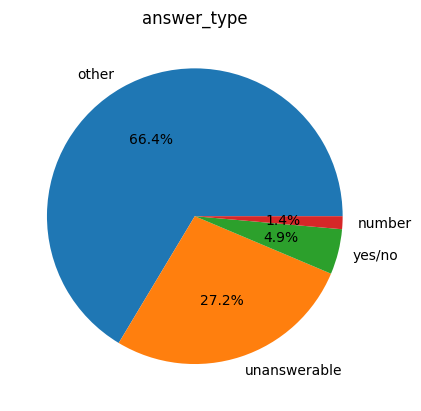

text:  ¿Qué es esto? ¿Qué programa está en la televisión? ¿Qué tipo de Kool-Aid es este? Espero que esto funcione. ¿Qué hay en esta lata por favor? ¿Qué hay en esta lata, por favor? ¿Qué es esto, por favor? ¿Qué es esta lata? ¿Qué es esto? ¿Puedes decir de qué marca es esto? ¿De qué color es esto, por favor? ¿Qué hay en la pantalla ahora? ¿Puedes por favor describirme qué hay en esta pantalla? Gracias ¿Qué programa es este? ¿Cuál es la fecha de vencimiento del huevo, por favor? ¿Qué es este objeto? ¿De qué color es esta botella de agua? Hola. ¿Podrías decirme por favor si esto es café descafeinado? ¿Qué es esto, por favor? ¿De qué color es este marcador fluorescente? ¿Qué es esta lata? ¿Qué temperatura indica este termostato? ¿De qué color son mis pantalones? ¿Qué es esto? Por favor, ¿podrías decirme qué hay en esta lata? Gracias. ¿Puedes decir qué dice esta camiseta? ¿Qué hay en estos? ¿Qué es esto? ¿Qué es esta botella? ¿Qué es esto? ¿Qué es esto y puedo escribir una pregunta en ento

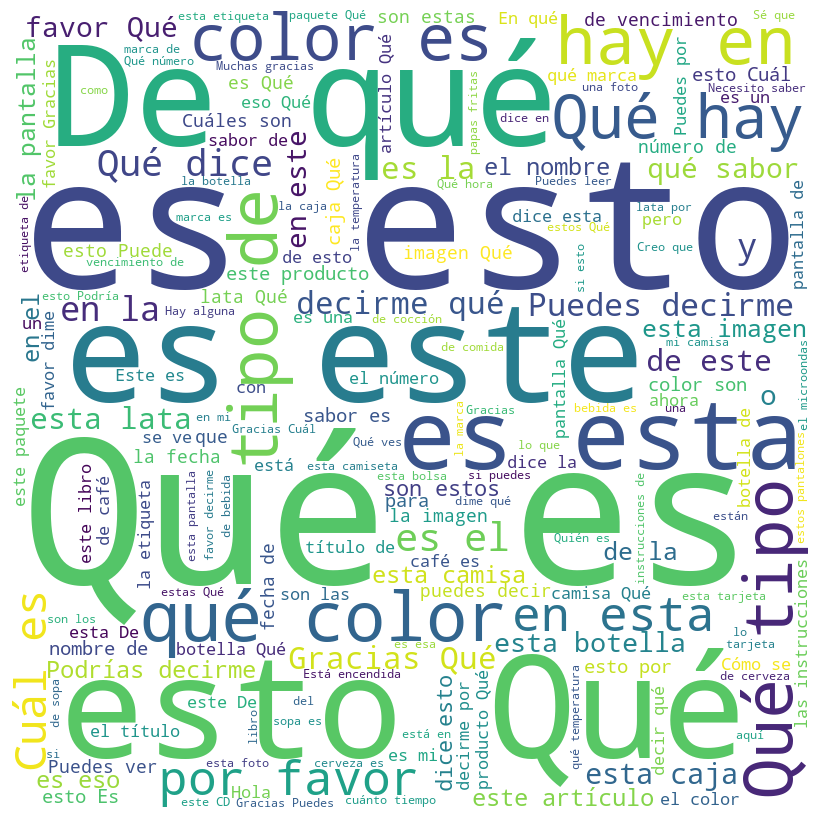

Worcloud de las question: 


In [21]:
#Training Dataframe
print('train_df.shape: ', train_df.shape)
print("Number of distinct answers: ", get_number_of_distinct_answers(train_df))
print("Number of samples in train: ", len(train_df))

explore_dataframe(train_df)
print('Worcloud de las question: ')

## Testing Dataset

test_df.shape:  (602, 5)
Number of distinct answers:  1552
Number of samples in train:  602


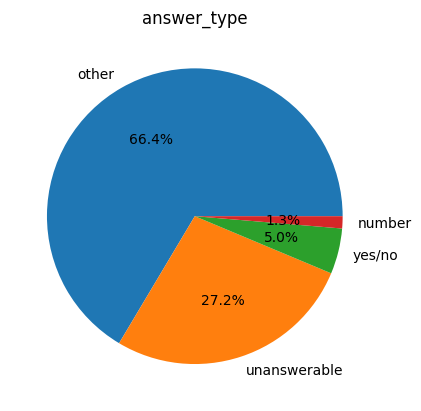

text:  ¿Cuáles son las opciones seleccionadas? ¿Qué hay en esta caja? ¿Puedes decirme qué es esto, por favor? ¿A qué está ajustado este dial? ¿Qué sabor de yogur es este? ¿Qué colores forman parte de este diseño? ¿Qué es este artículo? ¿Cuánto tiempo queda en esta secadora? ¿De qué color es la camisa que estoy usando? ¿Puedes decirme qué es este producto? ¿De qué color es esto? Por favor, gracias. ¿Qué tipo de cereal es este, por favor? Gracias. ¿Qué tipo de bebida hay dentro de esta lata? ¿Esto está pasado de la fecha de vencimiento? ¿Qué producto es este, por favor? Y gracias. ¿Qué tipo de pastillas hay en esta botella? ¿Qué es esta lata? ¿Estos pantalones combinan con esta camisa? ¿Qué es esta lata? ¿Qué es esto? ¿Qué es esto? ¿Qué tipo de revestimiento de piso? ¿Cuál es el color de esa camiseta y saludos desde Kuwait. ¿Qué hay en esta caja? ¿Qué es esta caja? Sé que es pudín, pero ¿qué tipo? Gracias. ¿Cuál es el color del vidrio y el marco? ¿Qué tipo de guitarra es esta? ¿Es esto u

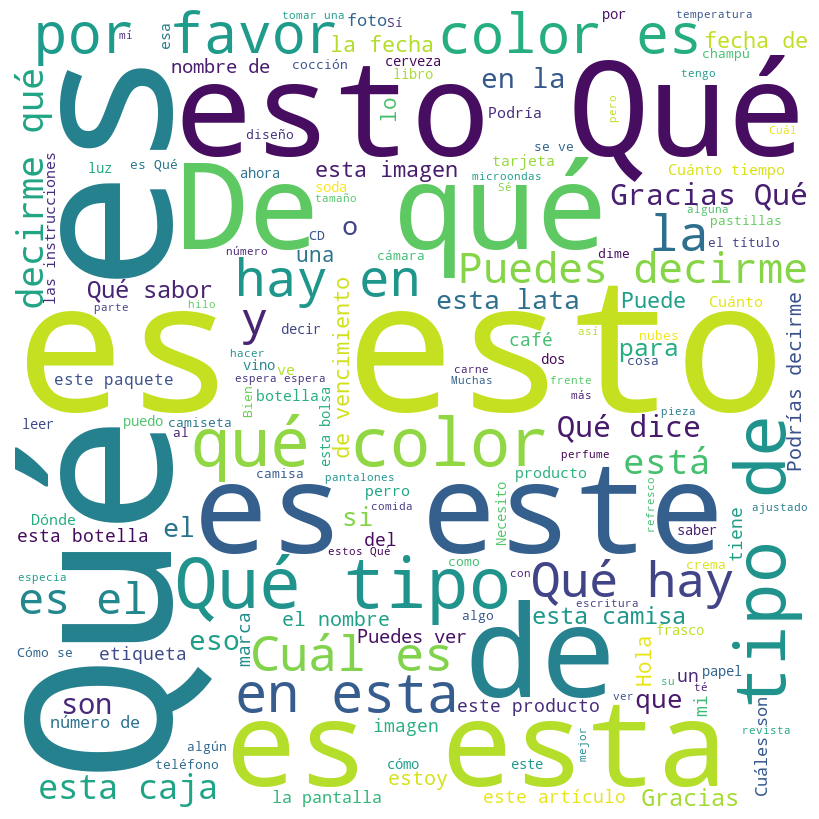

In [22]:
#Testing Dataframe
print('test_df.shape: ', test_df.shape)
print("Number of distinct answers: ", get_number_of_distinct_answers(test_df))
print("Number of samples in train: ", len(test_df))
explore_dataframe(test_df)

###  Validation Dataset

validation_df shape  (4301, 5)
Number of distinct answers:  9408
Number of samples in validation set:  4301


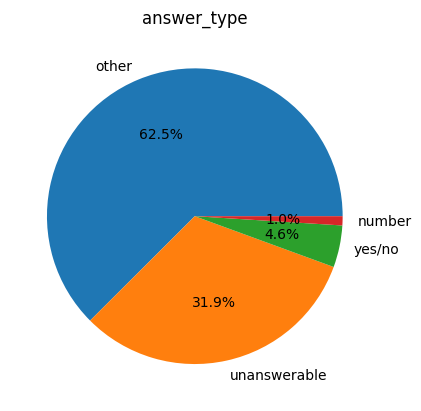

text:  Ok. Hay otra imagen, espero que sea mejor. ¿Me puedes decir por favor qué medicamento es este? ¿Cuál es el título de este libro? ¿Cuál es el azul? ¿Qué dice la flecha? ¿Qué dice la pantalla? Gracias. ¿Qué se ve en la pantalla de la laptop? ¿Qué se ve en la pantalla de la laptop? Está bien, creo que lo entendí esta vez. ¿Puedes leerme el modelo y número de serie? Gracias. ¿Es esto champú o acondicionador? ¿Puedes describirme qué está pasando afuera de la ventana? Solo por curiosidad. ¿Qué hay de la señalización? ¿De qué color es esto? ¿De quién es esta pieza de correo y de dónde viene? ¿Para quién es este correo? ¿Cómo se ve mi ojo? ¿Cuál de estos elementos es el diccionario de los niños? ¿Es el de la derecha o el de la izquierda? ¿Qué es esto? ¿Puedes verificar si esto es de 32 bits o de 64 bits? Gracias. ¿Qué está haciendo la computadora? ¿Cuál es el número de etiqueta? ¿Qué dice este letrero? ¿Cuál es este color y patrón? Hay algún tipo de patrón en mi pecho izquierdo. Describ

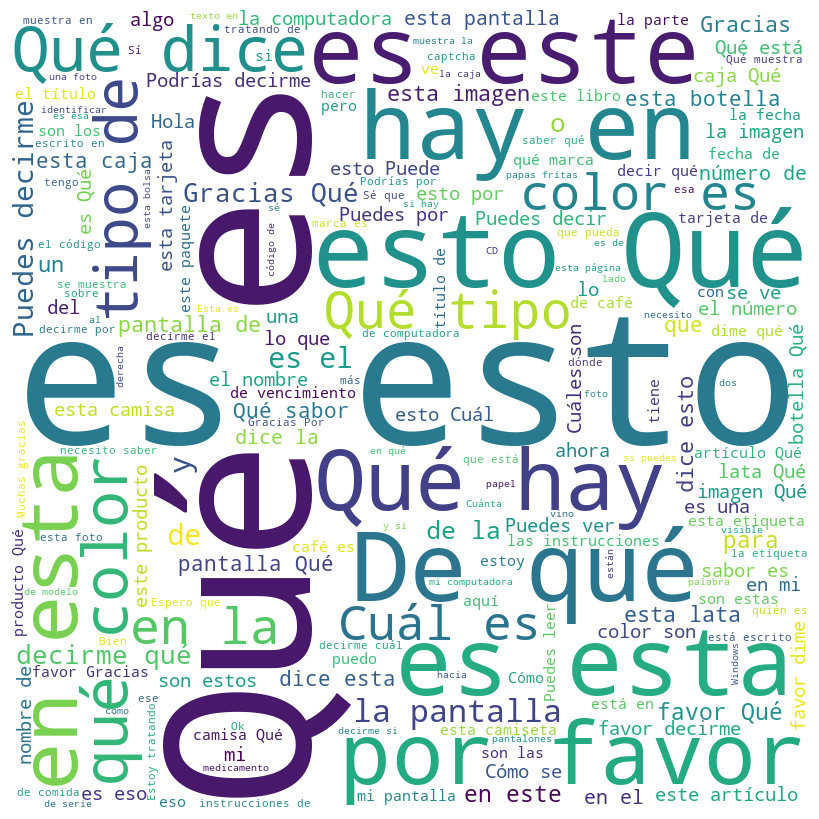

In [23]:
#Validation Dataframe
print('validation_df shape ', validation_df.shape)
print("Number of distinct answers: ", get_number_of_distinct_answers(validation_df))
print("Number of samples in validation set: ", len(validation_df))

explore_dataframe(validation_df)


# Processing Images & Questions using CLIP model

Instead of lazy processing of images and questions embeddings and recomputing them over and over during forward passes in the model, we can preprocess them and save them in a file using Pickle. This will save us a lot of time when we want to train our model and decrease the time taken by one epoch drastically.

In [165]:
#Este modelo solo tiene encoder de texto, para las imagenes tegno que cargar clip Vit

# We use the original clip-ViT-B-32 for encoding images
img_model = SentenceTransformer('clip-ViT-B-32') #gerenar features de size 512


# Our text embedding model is aligned to the img_model and maps 50+
# languages to the same vector space
text_model = SentenceTransformer('sentence-transformers/clip-ViT-B-32-multilingual-v1') #genera featues de size 512

/home/cvillalba/miniconda3/envs/tesisenv2/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


## Proceso las annotations (las preguntas o questions) y las guardo como .pkl

In [167]:
#Ejecutarlo 1 sola vez
#Esto es para pre procesar las imagenes y las preguntas, como ya lo tengo hecho en mi drive no es ncesario volver a ejecutarlo.
#Los leo directamente en la seccion Loading Preprocessed Embeddings

'''
print('Procesando questions...')

print('test_df')
test_questions = process_questions(test_df, text_model, DEVICE)
with open(OUTPUT_PATH + 'test_questions_trad_CLIP_MULTIL_new_sample.pkl', 'wb') as f:
    pickle.dump(test_questions, f)
print('test_questions len: ',len(test_questions))
print(test_questions[0].size())

print('train_df')
training_questions = process_questions(train_df, text_model, DEVICE)
with open(OUTPUT_PATH + 'training_questions_trad_CLIP_MULTIL_new_sample.pkl', 'wb') as f:
    pickle.dump(training_questions, f)
print('training_questions len: ',len(training_questions))   
print(training_questions[0].size())

print('validation_df')
validation_questions = process_questions(validation_df, text_model, DEVICE)
with open(OUTPUT_PATH + 'validation_questions_trad_CLIP_MULTIL_new_sample.pkl', 'wb') as f:
    pickle.dump(validation_questions, f)
print('validation_questions len: ',len(validation_questions))  
print(validation_questions[0].size())
'''

Procesando questions...
test_df


0it [00:00, ?it/s]

text_features size:  torch.Size([512])
test_questions len:  602
torch.Size([1, 512])
train_df


0it [00:00, ?it/s]

text_features size:  torch.Size([512])
training_questions len:  11437
torch.Size([1, 512])
validation_df


0it [00:00, ?it/s]

text_features size:  torch.Size([512])
validation_questions len:  4301
torch.Size([1, 512])


## Proceso las imagenes y las guardo como .pkl

In [168]:

#proceso las imagenes:

#voy a usar el modelo clip original pero solo para procesar las imagenes xq el otro melos deja en otro tamaño
#no pude usar este modelo xq me los deja en un tamao de 768 y las features de texto del multilingual es de 512
#al no coincidir me cancelaba
#print('Loading CLIP model...')
#clip_model, preprocessor = clip.load(MODEL_NAME, device = DEVICE)
#clip_model.eval().requires_grad_(False)
'''
print('Procesando imagenes....',img_model)

test_images = process_images(test_df, IMAGES_PATH, img_model, DEVICE)
#process_images_orig(test_df, IMAGES_PATH, clip_model,preprocessor, DEVICE) 
with open(OUTPUT_PATH + 'test_images_CLIP_ViTB32_new_sample.pkl', 'wb') as f:
    pickle.dump(test_images, f)
print('test_images len: ',len(test_images))
print(test_images[0].size())

training_images = process_images(train_df, IMAGES_PATH, img_model, DEVICE)
#process_images_orig(train_df, IMAGES_PATH, clip_model,preprocessor, DEVICE)
with open(OUTPUT_PATH + 'training_images_CLIP_ViTB32_new_sample.pkl', 'wb') as f:
    pickle.dump(training_images, f)
print('training_images len: ',len(training_images))
print(training_images[0].size())

validation_images = process_images(validation_df, IMAGES_PATH, img_model, DEVICE)
#process_images_orig(validation_df, IMAGES_PATH, clip_model,preprocessor, DEVICE)
with open(OUTPUT_PATH + 'validation_images_CLIP_ViTB32_new_sample.pkl', 'wb') as f:
    pickle.dump(validation_images, f)
print('validation_images len: ',len(validation_images))
print(validation_images[0].size())
'''

Procesando imagenes.... SentenceTransformer(
  (0): CLIPModel()
)


0it [00:00, ?it/s]

image_features size:  torch.Size([1, 512])
test_images len:  602
torch.Size([1, 512])


0it [00:00, ?it/s]

image_features size:  torch.Size([1, 512])
training_images len:  11437
torch.Size([1, 512])


0it [00:00, ?it/s]

image_features size:  torch.Size([1, 512])
validation_images len:  4301
torch.Size([1, 512])


# Loading Preprocessed Embeddings

Cargo los dataset que habia procesador anteriormente y guarde como .pkl

In [26]:
with open(OUTPUT_PATH + 'training_images_CLIP_ViTB32_new_sample.pkl', 'rb') as f:
    training_images = pickle.load(f)
#with open(OUTPUT_PATH + 'training_questions_trad_CLIP-orig.pkl', 'rb') as f:
with open(OUTPUT_PATH + 'training_questions_trad_CLIP_MULTIL_new_sample.pkl', 'rb') as f:    
    training_questions = pickle.load(f)

with open(OUTPUT_PATH + 'validation_images_CLIP_ViTB32_new_sample.pkl', 'rb') as f:
    validation_images = pickle.load(f)
#with open(OUTPUT_PATH + 'validation_questions_trad_CLIP-orig.pkl', 'rb') as f:
with open(OUTPUT_PATH + 'validation_questions_trad_CLIP_MULTIL_new_sample.pkl', 'rb') as f:
    validation_questions = pickle.load(f)

with open(OUTPUT_PATH + 'test_images_CLIP_ViTB32_new_sample.pkl', 'rb') as f:
    test_images = pickle.load(f)
#with open(OUTPUT_PATH + 'test_questions_trad_CLIP-orig.pkl', 'rb') as f:
with open(OUTPUT_PATH + 'test_questions_trad_CLIP_MULTIL_new_sample.pkl', 'rb') as f:
    test_questions = pickle.load(f)

In [27]:
print(training_questions[0].shape)
print(training_images[0].shape)

torch.Size([1, 512])
torch.Size([1, 512])


In [28]:
print(training_questions[0].size())
print(training_images[0].size())
print(validation_questions[0].size())
print(validation_images[0].size())
print(test_questions[0].size())
print(test_images[0].size())

torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])


In [40]:
print('training_questions len: ',len(training_questions))
print('training_images len: ',len(training_images))
print('train_df shape: ', train_df.shape)
print('validation_questions len: ',len(validation_questions))
print('validation_images len: ', len(validation_images))
print('validation_df shape: ', validation_df.shape)
print('test_questions len: ',len(test_questions))
print('test_images len: ', len(test_images))
print('test_df len: ', test_df.shape)

training_questions len:  11437
training_images len:  11437
train_df shape:  (11437, 5)
validation_questions len:  4301
validation_images len:  4301
validation_df shape:  (4301, 5)
test_questions len:  602
test_images len:  602
test_df len:  (602, 5)


# Preparing Data Loaders

In [31]:
print(train_df.columns)
print(train_df.answer_type.unique())
print(train_df.answerable.unique())


Index(['image', 'question', 'answers', 'answer_type', 'answerable'], dtype='object')
['other' 'unanswerable' 'yes/no' 'number']
[1 0]


In [33]:
# Preparing Data Loaders
# Constructing the training dataset
training_dataset = VizWizDataset(train_df, None, None, MODEL_NAME, training_images, training_questions)
ANSWER_ONEHOTENCODER = training_dataset.answer_onehotencoder
ANSWER_TYPE_ONEHOTENCODER = training_dataset.answer_type_onehotencoder
print('ANSWER_ONEHOTENCODER: ', ANSWER_ONEHOTENCODER)
print('ANSWER_TYPE_ONEHOTENCODER: ', ANSWER_TYPE_ONEHOTENCODER)
# Saving the fitted one hot encoders
with open(OUTPUT_PATH + 'answer_onehotencoder_trad_CLIP_MultiL_new_sample.pkl', 'wb') as f:
    pickle.dump(ANSWER_ONEHOTENCODER, f)
with open(OUTPUT_PATH + 'answer_type_onehotencoder_trad_CLIP_MultiL_new_sample.pkl', 'wb') as f:
    pickle.dump(ANSWER_TYPE_ONEHOTENCODER, f)

 

# Constructing the validation dataset
validation_dataset = VizWizDataset(validation_df, ANSWER_TYPE_ONEHOTENCODER, ANSWER_ONEHOTENCODER, MODEL_NAME, validation_images, validation_questions)

# Constructing the test dataset
test_dataset = VizWizDataset(test_df, ANSWER_TYPE_ONEHOTENCODER, ANSWER_ONEHOTENCODER, MODEL_NAME, test_images, test_questions)

# Configuring the data loaders
BATCH_SIZE = 32 # 16,64 is good too but 32 is better (variance wise)


training_dataloader = DataLoader(training_dataset, batch_size=BATCH_SIZE, shuffle=True) #,collate_fn=collate_fn)
validation_dataloader = DataLoader(validation_dataset, batch_size=BATCH_SIZE ) #,collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE) #,collate_fn=collate_fn)

print('train_df shape: ', train_df.shape)
print('train_df shape: ', validation_df.shape)
print('train_df shape: ', test_df.shape)

print('training_dataset shape: ', len(training_dataset))
print('training_dataset shape: ', len(validation_dataset))
print('training_dataset shape: ', len(test_dataset))

print('training_dataloader shape: ', len(training_dataloader))
print('validation_dataloader shape: ', len(validation_dataloader))
print('test_dataloader shape: ', len(test_dataloader))



build_answer_vocab
Number of distinct answers:  3759
ANSWER_ONEHOTENCODER:  OneHotEncoder(handle_unknown='ignore')
ANSWER_TYPE_ONEHOTENCODER:  OneHotEncoder(handle_unknown='ignore')
build_answer_vocab
Number of distinct answers:  1585
build_answer_vocab
Number of distinct answers:  308
train_df shape:  (11437, 5)
train_df shape:  (4301, 5)
train_df shape:  (602, 5)
training_dataset shape:  11437
training_dataset shape:  4301
training_dataset shape:  602
training_dataloader shape:  358
validation_dataloader shape:  135
test_dataloader shape:  19


'\nNumber of distinct answers TRAIN orig:  2423\nNumber of distinct answers VALIDATION orig :  883\nNumber of distinct answers TEST orig :  220\nNumber of distinct answers:  2536\nNumber of distinct answers:  858\nNumber of distinct answers:  227\n\n'

In [35]:
print(ANSWER_ONEHOTENCODER.categories_)
print(ANSWER_TYPE_ONEHOTENCODER.categories_)

[array(['$1 singapur', '$1.05', '$100.81', ..., 'ónix negro',
       'última cena',
       'únete a nosotros el 21 de marzo en la oficina de arrendamiento de Icon de 6 a 8 pm masajes gratuitos cortesía de'],
      dtype=object)]
[array(['number', 'other', 'unanswerable', 'yes/no'], dtype=object)]


# Training the Model

Son 50 epocas y se va guardando los checkpoint cada 5 epocas.

In [37]:
import warnings
warnings.filterwarnings("ignore")

# Configuring training's hyperparameters
NUM_EPOCHS = 50
LR = 5e-4
WEIGHT_DECAY = 0
NUM_CLASSES = len(training_dataset.get_answer_vocab())
SAVE_PATH = OUTPUT_PATH
SAVE_EVERY = 5
print('NUM_CLASSES: ', NUM_CLASSES)
print('SAVE_PATH: ', SAVE_PATH)

# Initializing the model
model = VQAModel(num_classes=NUM_CLASSES, device= DEVICE, hidden_size=512, img_model = IMAGE_MODEL,TEXT_MODEL = TEXT_MODEL).to(DEVICE)
#model.print_CLIP_model()


#for name, param in model.named_parameters():
#    print(f"{name}: {param.size()}")

# Initializing the loss function and optimizer
loss_function = nn.CrossEntropyLoss().to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay = WEIGHT_DECAY)

# Training the model and plotting the loss and accuracy
model.train_model(training_dataloader, validation_dataloader, test_dataloader, loss_function, optimizer, epochs=NUM_EPOCHS, save_path=SAVE_PATH, save_every=SAVE_EVERY)

model.plot_loss()
model.plot_accuracy()
model.plot_vizwiz_accuracy()
model.plot_answerability()

NUM_CLASSES:  3759
SAVE_PATH:  /home/cvillalba/data/data3/VQA/Tesis/TesisVQA/TesisVQA/VQA-MULTI-ESP/modelos/
image model:  clip-ViT-B-32
SentenceTransformer(
  (0): CLIPModel()
) <generator object Module.parameters at 0x7fcdf06660b0>
text model
SentenceTransformer(
  (0): Transformer({'max_seq_length': 128, 'do_lower_case': False}) with Transformer model: DistilBertModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Dense({'in_features': 768, 'out_features': 512, 'bias': False, 'activation_function': 'torch.nn.modules.linear.Identity'})
)
128
hidden_size:  512
num_classes:  3759
self.visual_output_dim:  512
training_step


0it [00:00, ?it/s]

batch:  6
batch:  6
batch:  6
batch:  6
batch:  6
batch:  6
batch:  6
batch:  6
batch:  6
batch:  6
batch:  6
batch:  6
batch:  6
batch:  6
batch:  6
batch:  6
batch:  6
batch:  6
batch:  6
batch:  6
batch:  6
batch:  6
batch:  6
batch:  6
batch:  6
batch:  6
batch:  6
batch:  6
batch:  6
batch:  6
batch:  6
batch:  6
batch:  6
batch:  6
batch:  6
batch:  6
batch:  6
batch:  6
batch:  6
batch:  6
batch:  6
batch:  6
batch:  6
batch:  6
batch:  6
batch:  6
batch:  6
batch:  6
batch:  6
batch:  6
batch:  6
batch:  6
batch:  6
batch:  6
batch:  6
batch:  6
batch:  6
batch:  6
batch:  6
batch:  6
batch:  6
batch:  6
batch:  6
batch:  6
batch:  6
batch:  6
batch:  6
batch:  6
batch:  6
batch:  6
batch:  6
batch:  6
batch:  6
batch:  6
batch:  6
batch:  6
batch:  6
batch:  6
batch:  6
batch:  6
batch:  6
batch:  6
batch:  6
batch:  6
batch:  6
batch:  6
batch:  6
batch:  6
batch:  6
batch:  6
batch:  6
batch:  6
batch:  6
batch:  6
batch:  6
batch:  6
batch:  6
batch:  6
batch:  6
batch:  6


KeyboardInterrupt: 

# Test your own image!

The following part of code allows the user to test his own image using the trained model. You just have to configure IMAGE_PATH and QUESTION variables and run the cell.

Cargo el mejor modelo otenido arriba y pruebo con una imagen

Paths:
INPUT_PATH:  /home/cvillalba/data/data3/VQA/Tesis/TesisVQA/TesisVQA/VQA-MULTI-ESP/Datasets/
IMAGE_PATH:  /home/cvillalba/data/data3/VQA/Tesis/TesisVQA/TesisVQA/VQA-MULTI-ESP/Datasets/Images/images/VizWiz_train_00009690.jpg
OUTPUT_PATH:  /home/cvillalba/data/data3/VQA/Tesis/TesisVQA/TesisVQA/VQA-MULTI-ESP/modelos/
image model:  clip-ViT-B-32
SentenceTransformer(
  (0): CLIPModel()
) <generator object Module.parameters at 0x7ffa8dbacc10>
text model
SentenceTransformer(
  (0): Transformer({'max_seq_length': 128, 'do_lower_case': False}) with Transformer model: DistilBertModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Dense({'in_features': 768, 'out_features': 512, 'bias': False, 'activation_function': 'torch.nn.modules.linear

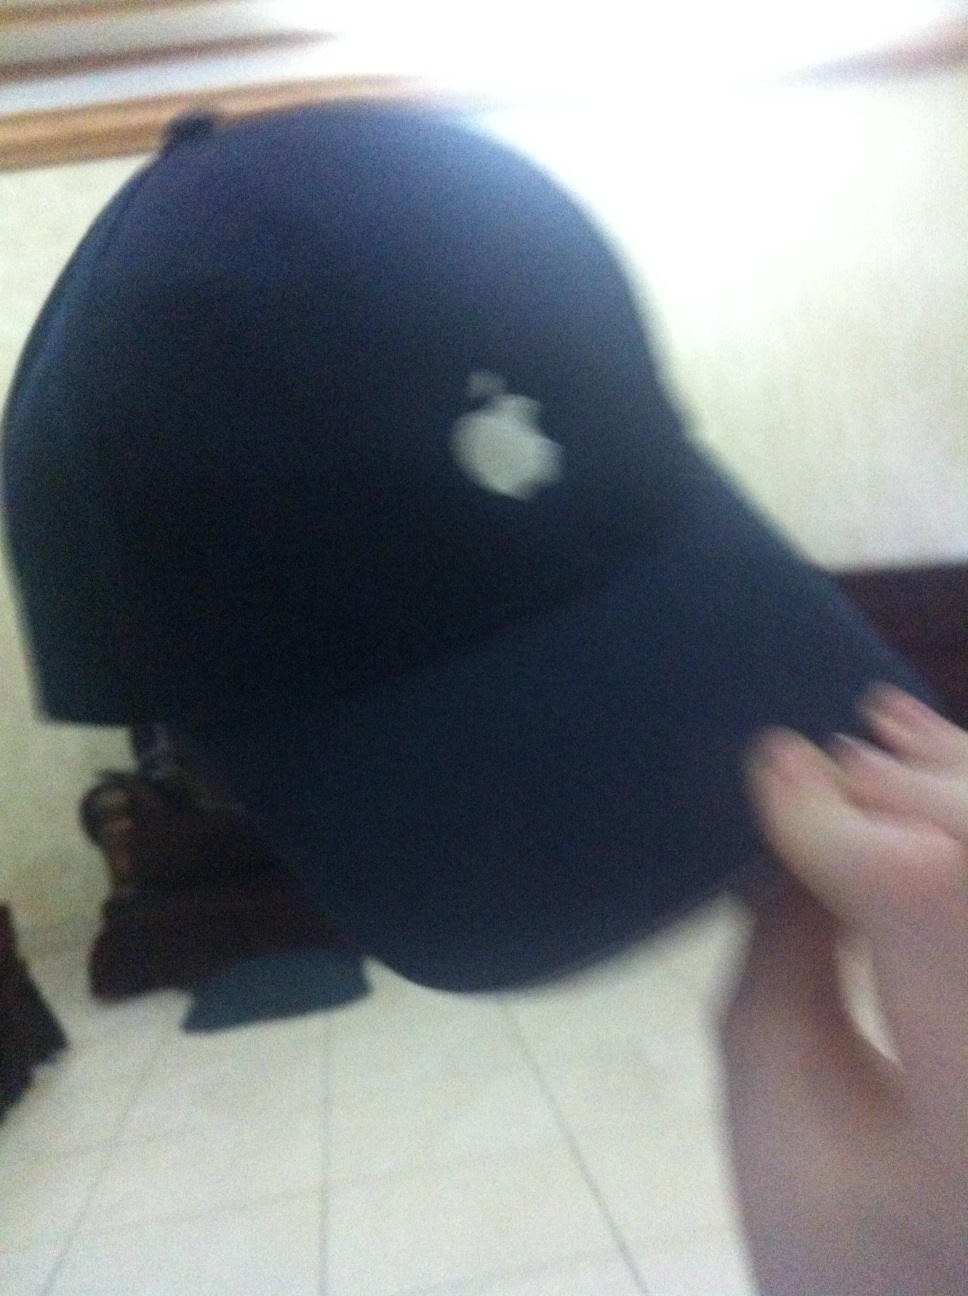

In [184]:


INPUT_PATH = '/home/cvillalba/data/data3/VQA/Tesis/TesisVQA/TesisVQA/VQA-MULTI-ESP/Datasets/'
IMAGES_PATH = INPUT_PATH + 'Images/images/'

# Taking a sample image and question from the user
QUESTION = "¿Qué es esto?"
#"can you read this label?"
#"What kind of food is this?"
IMAGE_PATH =IMAGES_PATH + 'VizWiz_train_00009690.jpg'
#'VizWiz_train_00010546.jpg.jpg'
# "/kaggle/input/vizwiz/train/train/VizWiz_train_00000008.jpg"

OUTPUT_PATH = '/home/cvillalba/data/data3/VQA/Tesis/TesisVQA/TesisVQA/VQA-MULTI-ESP/modelos/'

print('Paths:')
print('INPUT_PATH: ', INPUT_PATH)
print('IMAGE_PATH: ', IMAGE_PATH)
print('OUTPUT_PATH: ', OUTPUT_PATH)

# Loading the fitted One Hot Encoders from the disk
with open(OUTPUT_PATH + 'answer_onehotencoder_trad_CLIP_MultiL_new_sample.pkl', 'rb') as f:
    ANSWER_ONEHOTENCODER = pickle.load(f)
with open(OUTPUT_PATH + 'answer_type_onehotencoder_trad_CLIP_MultiL_new_sample.pkl', 'rb') as f:
    ANSWER_TYPE_ONEHOTENCODER = pickle.load(f)

# Loading the model from the disk
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#MODEL_NAME = "ViT-L/14@336px"
NUM_CLASSES = len(training_dataset.get_answer_vocab())
MODEL_PATH = OUTPUT_PATH + 'epoch_35_multi_new.pth'
#'epoch_45_multi.pth' #'epoch_45.pth'
#MODEL_PATH = "/kaggle/working/epoch_45.pth" # OUTPUT_PATH + 'model.pt'
IMAGE_MODEL = 'clip-ViT-B-32'
TEXT_MODEL = 'sentence-transformers/clip-ViT-B-32-multilingual-v1'
model = VQAModel(num_classes=NUM_CLASSES, device= DEVICE, hidden_size=512, img_model = IMAGE_MODEL,TEXT_MODEL = TEXT_MODEL).to(DEVICE)
model.load_model(MODEL_PATH)

# Predicting the answer and answer type
predicted_answer, predicted_answer_type, answerability = model.test_model(image_path = IMAGE_PATH, question = QUESTION)
predicted_answer= predicted_answer.reshape(1, -1)
predicted_answer_type= predicted_answer_type.reshape(1, -1)
answer = ANSWER_ONEHOTENCODER.inverse_transform(predicted_answer.cpu().detach().numpy())
answer_type = ANSWER_TYPE_ONEHOTENCODER.inverse_transform(predicted_answer_type.cpu().detach().numpy())

# Printing the answer and answer type

print('Question: ', QUESTION)
print("The Answer is: " + answer[0][0])
print("The Answer Type is: " + answer_type[0][0])
print("The confidence for being unanswerable: " + str(answerability.item()))
display(Image.open(IMAGE_PATH).convert('RGB'))

# Corro el modelo sobre el dataset de validacion para calcular el accuracy final

## Building Test Answers


In [185]:
from collections import Counter
def most_common_element(lst):
    # Count occurrences of each element in the list
    count_dict = Counter(lst)

    # Find the most common element and its count
    most_common = count_dict.most_common(1)

    if most_common:
        return most_common[0][0]
    else:
        return None
# Example usage:
my_list = ["apple", "banana", "orange", "apple", "banana", "apple", "pear"]
result = most_common_element(my_list)

if result is not None:
    print(f"The most common element is: {result}")
else:
    print("The list is empty.")



The most common element is: apple


In [186]:

# Configuring the paths for the dataset
INPUT_PATH = '/home/cvillalba/data/data3/VQA/Tesis/TesisVQA/TesisVQA/VQA-MULTI-ESP/Datasets/'
#ANNOTATIONS = INPUT_PATH + '/annotations'
IMAGES_PATH = INPUT_PATH + 'Images/images/'
VALIDATION_PATH = INPUT_PATH
VALIDATION_FILE= 'VizWiz_val_new_trad_correct.csv' #nuevo dataset de validacion con 4301 samples
#'data_val_trad_GPT_CLIP_caption_detail_new.csv' #archivo traducido + captions nuevo split
ANNOTATIONS_VAL_PATH = INPUT_PATH + VALIDATION_FILE

#df = pd.read_csv(ANNOTATIONS_VAL_PATH)
#df['answers']=df['answers'].apply(lambda x: eval(x))
#df = df[['image', 'question','answers','answer_type']]

df = read_dataframe(ANNOTATIONS_VAL_PATH)
#Agrego una columna con la respuesta mas frecuente en la lista de respuestas 
df['answer']=df.apply(lambda x: most_common_element(x.answers),axis=1)
print(df.shape)
df.head()

(4301, 6)


image  \
0  VizWiz_val_00000000.jpg   
1  VizWiz_val_00000001.jpg   
2  VizWiz_val_00000002.jpg   
3  VizWiz_val_00000003.jpg   
4  VizWiz_val_00000004.jpg   

                                              question  \
0           Ok. Hay otra imagen, espero que sea mejor.   
1  ¿Me puedes decir por favor qué medicamento es este?   
2                    ¿Cuál es el título de este libro?   
3                                    ¿Cuál es el azul?   
4                                 ¿Qué dice la flecha?   

                                                                                                                                                                                              answers  \
0  [sin respuesta, sin respuesta, sin respuesta, sin respuesta, sin respuesta, sin respuesta, sin respuesta, sin respuesta, no se puede reparar esta computadora automáticamente, pantalla en blanco]   
1                [Hora de la noche, Hora de la noche, Hora de la noche, Hora de la noche, Hora de la noche, Hora de la noche, Hora de la noche, Hora de la noche, Hora de la noche, Hora de la noche]   
2                                              [años de perro, años de perro, años de perro, años de perro, años de perro, años de perro, años de perro, años de perro, años de perro, años de perro]   
3                                                                                                          [derecha, derecha, derecha, derecha, derecha, derecha, derecha, derecha, derecha, derecha]   
4                                                        [sin respuesta, sin respuesta, zoomtext, sin respuesta, sin respuesta, sin respuesta, sin respuesta, sin respuesta, sin respuesta, zoomtext]   

    answer_type  answerable            answer  
0  unanswerable           0     sin respuesta  
1         other           1  Hora de la noche  
2         other           1     años de perro  
3         other           1           derecha  
4  unanswerable           0     sin respuesta

In [190]:
from tqdm import tqdm
#df = pd.read_json("/kaggle/input/vizwiz/Annotations/Annotations/test.json")
#df = df[['image', 'question']]

# let's create two json objects to store the output of the model then write them to a file
model_answers = []
model_answerability = []

for i in tqdm(range(len(df))):
    image_url = df['image'][i]
    question = df['question'][i]
    answers =df['answers'][i]
    ground_true_ans = df['answer'][i]
    answer_type = df['answer_type'][i]
    image_path = '/home/cvillalba/data/data3/VQA/Tesis/TesisVQA/TesisVQA/VQA-MULTI-ESP/Datasets/Images/images/' + image_url #+ '.jpg'
    predicted_answer, predicted_answer_type, answerability = model.test_model(image_path = image_path, question = question)
    predicted_answer= predicted_answer.reshape(1, -1)
    predicted_answer_type= predicted_answer_type.reshape(1, -1)
    answer = ANSWER_ONEHOTENCODER.inverse_transform(predicted_answer.cpu().detach().numpy())
    answer_type = ANSWER_TYPE_ONEHOTENCODER.inverse_transform(predicted_answer_type.cpu().detach().numpy())
    answer_result = {'image': image_url, 'question': question, 'answers': answers, 'ground_true_ans': ground_true_ans,'answer': answer[0][0],'answer_type':answer_type[0][0]}
    answerability_result = {'image': image_url, 'question': question,'ground_true_ans': ground_true_ans,'answerability': answerability.item()}
    model_answers.append(answer_result)
    model_answerability.append(answerability_result)

# Writing them using pickle
#with open(OUTPUT_PATH + 'answers_results.json', 'w') as file:
with open(OUTPUT_PATH + 'answers_results_trad_CLIP_MultiL.json', 'w') as file:
    json.dump(model_answers, file)
#with open(OUTPUT_PATH + 'answerability_results.json', 'w') as file:
with open(OUTPUT_PATH + 'answerability_results_trad_CLIP_MultiL.json', 'w') as file:
    json.dump(model_answerability, file)


100%|██████████| 4301/4301 [10:28<00:00,  6.85it/s]


In [191]:
model_answers_df = pd.DataFrame(model_answers)
model_answers_df

image  \
0     VizWiz_val_00000000.jpg   
1     VizWiz_val_00000001.jpg   
2     VizWiz_val_00000002.jpg   
3     VizWiz_val_00000003.jpg   
4     VizWiz_val_00000004.jpg   
...                       ...   
4296  VizWiz_val_00004314.jpg   
4297  VizWiz_val_00004315.jpg   
4298  VizWiz_val_00004316.jpg   
4299  VizWiz_val_00004317.jpg   
4300  VizWiz_val_00004318.jpg   

                                                                                            question  \
0                                                         Ok. Hay otra imagen, espero que sea mejor.   
1                                                ¿Me puedes decir por favor qué medicamento es este?   
2                                                                  ¿Cuál es el título de este libro?   
3                                                                                  ¿Cuál es el azul?   
4                                                                               ¿Qué dice la flecha?   
...                                                                                              ...   
4296                                                                                   ¿Qué es esto?   
4297                                                                               ¿Es esto moderno?   
4298  Necesito comprar esta batería para mi teléfono inalámbrico, ¿puedes ver el modelo y el nombre?   
4299                                                                    ¿Qué tipo de mezcla es esta?   
4300                                                                   ¿Qué tipo de especia es esta?   

                                                                                                                                                                                                                                     answers  \
0                                         [sin respuesta, sin respuesta, sin respuesta, sin respuesta, sin respuesta, sin respuesta, sin respuesta, sin respuesta, no se puede reparar esta computadora automáticamente, pantalla en blanco]   
1                                                       [Hora de la noche, Hora de la noche, Hora de la noche, Hora de la noche, Hora de la noche, Hora de la noche, Hora de la noche, Hora de la noche, Hora de la noche, Hora de la noche]   
2                                                                                     [años de perro, años de perro, años de perro, años de perro, años de perro, años de perro, años de perro, años de perro, años de perro, años de perro]   
3                                                                                                                                                 [derecha, derecha, derecha, derecha, derecha, derecha, derecha, derecha, derecha, derecha]   
4                                                                                               [sin respuesta, sin respuesta, zoomtext, sin respuesta, sin respuesta, sin respuesta, sin respuesta, sin respuesta, sin respuesta, zoomtext]   
...                                                                                                                                                                                                                                      ...   
4296  [Aderezo para ensalada lado posterior, aderezo, aderezo para ensaladas, aderezo para ensalada, Aderezo de ensalada balsámico, aderezo para ensalada, inadecuado, aderezo para ensaladas, aderezo para ensalada, aderezo para ensalada]   
4297                                                                                                  [sin respuesta, no, sin respuesta, sin respuesta, sin respuesta, sin respuesta, sin respuesta, no lo sé, sin respuesta, sin respuesta]   
4298                                                                                                                   [sin respuesta, no, sin respuesta, sin respuesta, sin respuesta, sin respuesta, no, no, sin respues

In [192]:
#model_answers_df.to_csv('/home/cvillalba/data/data3/VQA/Tesis/TesisVQA/TesisVQA/VQA-MULTI-ESP/Datasets/model_answers_CLIP_MULTIL_new_sample.csv')

In [29]:
from sklearn.metrics import accuracy_score, f1_score

print('acc: ',accuracy_score(model_answers_df['ground_true_ans'], model_answers_df['answer']))
print('f1 score: ', f1_score(model_answers_df['ground_true_ans'], model_answers_df['answer'], average='macro'))

acc:  0.34885245901639345
f1 score:  0.09747722858533492
